# **Prevendo os Preços das Ações da IBM - Usando RNN**



## Introdução

O mercado de ações está em evidência, e há cada vez mais investidores interessados nele. Uma ação representa a menor parcela do capital de uma empresa. Quem compra ações de uma companhia adquire também os direitos — e os deveres — de um sócio.

Uma das principais vantagens de se tornar acionista de uma empresa é poder se beneficiar de parte dos resultados que ela obtiver. Quando uma companhia aberta tem lucro, uma parcela dele é distribuída aos sócios na forma de dividendos, na proporção do número de ações que cada um possuir.

Os dados do mercado de ações são interessantes de analisar e, como um incentivo adicional, modelos preditivos fortes podem ter grande retorno financeiro. 

Podemos criar um modelo preditivo usando Redes Neurais Recorrentes (Recurrent Neural Networks - RNN). Em uma rede neural recorrente, armazenamos as ativações de saída de uma ou mais camadas da rede.  Então, da próxima vez que fornecermos um dados de entrada à rede, incluiremos as saídas armazenadas anteriormente como entradas adicionais.

## Objetivo

Desenvolver um modelo de RNN que possa prever as altas dos preçoss do mercado e permitir que você faça negociações informadas estatisticamente.

## Dataset

O dataset contém 13 anos de dados (2006 a 2018) de estoque da empresa IBM. As colunas do arquivo são:

* Open - preço da ação na abertura do mercado (estes são os dados da NYSE, então tudo em dólar americano)

* High - preço mais alto alcançado no dia

* Low Close - Menor preço alcançado no dia

* Volume - Número de ações negociadas

* Name - o nome do ticker da ação (Consiste em uma forma de abreviar o nome de uma ação para facilitar as negociações e a identificação.)

Link do dataset: <a href="https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231" target="_blanc">DJIA 30 Stock Time Series<a/>

## 1. Importando as Bibliotecas e os Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD

In [3]:
dataset = pd.read_csv('./IBM_2006-01-01_to_2018-01-01.csv',index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


## 2. Dividindo os Dados

Vamos dividir os dados em conjunto de treino e de teste. Os dados dos anos de 2006 a 2016 serão usados para treinar o modelo, os dados dos anos de 2017 e 2018 serão deixados para testar o modelo.

In [4]:
#treino
training_set = dataset[:'2016'].iloc[:,1:2].values

#teste
test_set = dataset['2017':].iloc[:,1:2].values

Antes de começar a criar os modelos, vamos visualizar os conjuntos de dados. Como queremos prever as altas dos preços, usaremos a coluna 'High'.

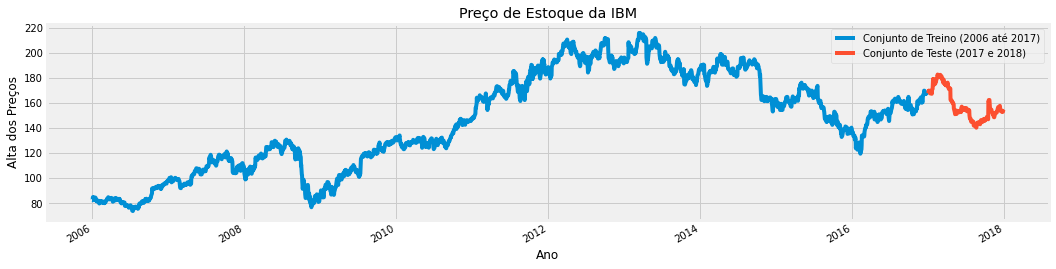

In [19]:
plt.figure(figsize=(10,9))
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Conjunto de Treino (2006 até 2017)','Conjunto de Teste (2017 e 2018)'])
plt.title('Preço de Estoque da IBM')
plt.xlabel("Ano")
plt.ylabel("Alta dos Preços")
plt.show()

Do gráfico acima vemos claramente a divisão entre os preços de treino (azul) e de teste (laranja). Nosso objetivo é criar modelos que consigam reproduzir (prever) esses dados de treino.

## 3. Preprocessando os dados

Temos que preprocessar os dados para melhorar a eficiência do modelo. Começamos padronizando os dados, deixando-os em valores variando entre mínimo de 0 e máximo 1.

In [6]:
# padroniza os dados
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

Como os modelos usam daods anteriores como entrada, criamos uma estrutura de dados com 60 passos de tempo e 1 saída. Portanto, para cada elemento do conjunto de treinamento, temos 60 elementos do conjunto de treinamento anterior.

In [7]:
# cria listas para salvar os elementos do conjunto
X_train = []
y_train = []

#pega os elementos "i" e os 60 anteriores "i-60"
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])

# transforma as listas em vetores do tipo numpy
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
# reescala o formato dos tensores adicionando uma dimensão a mais
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

## 4. Modelo1: LTSM

Memória longa de curto prazo (Long short-term memory - LSTM) são unidades de construção para camadas de RNN. Uma unidade LSTM comum é composta por uma célula, um portão de entrada, um portão de saída e um portão de esquecimento. A célula é responsável por "lembrar" valores em intervalos de tempo arbitrários; daí a palavra "memória" em LSTM. Intuitivamente, podem ser pensados ​​como reguladores do fluxo de valores que passa pelas conexões do LSTM; daí a denotação "portão". Existem conexões entre esses portões e a célula.

A expressão memória longa de curto prazo refere-se ao fato de que o LSTM é um modelo para a memória de curto prazo que pode perdurar por um longo período de tempo. Podemos agora criar o modelo de rede neural.

In [9]:
# arquitetura o modelo
regressor = Sequential()
# camada de entrada
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# 1° camada LSTM
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# 2° camada LSTM 
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# 3° camada LSTM 
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# camada de saída
regressor.add(Dense(units=1))

# imprime a arquitetura do modelo
regressor.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [10]:
# Compilando o RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

# Ajustando (fitting) o modelo com os dados de treino
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 33s 120ms/step - loss: 0.0567
Epoch 2/50
85/85 [==============================] - 20s 231ms/step - loss: 0.0106
Epoch 3/50
85/85 [==============================] - 12s 144ms/step - loss: 0.0082
Epoch 4/50
85/85 [==============================] - 10s 116ms/step - loss: 0.0062
Epoch 5/50
85/85 [==============================] - 10s 117ms/step - loss: 0.0070
Epoch 6/50
85/85 [==============================] - 10s 116ms/step - loss: 0.0055
Epoch 7/50
85/85 [==============================] - 10s 116ms/step - loss: 0.0043
Epoch 8/50
85/85 [==============================] - 10s 116ms/step - loss: 0.0047
Epoch 9/50
85/85 [==============================] - 10s 116ms/step - loss: 0.0038
Epoch 10/50
85/85 [==============================] - 10s 115ms/step - loss: 0.0042
Epoch 11/50
85/85 [==============================] - 10s 116ms/step - loss: 0.0033
Epoch 12/50
85/85 [==============================] - 10s 122ms/step - loss: 0.0033
Epoch 13/50
8

Agora preparamos o conjunto de teste de maneira semelhante ao conjunto de treinamento. Foram feitos que 60 entradas do conjunto de teste tenham 60 valores anteriores do atributo 'High' para processamento.

In [11]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values

#reestrutura os vetores
inputs = inputs.reshape(-1,1)
# padroniza os dados
inputs  = sc.transform(inputs)

## 5. Avaliando o Modelo1 LSTM

In [12]:
# preparando os preços de X_test e das previsões
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

Vamos calcular a raiz do erro quadrático médio para ver a qualidade do modelo.

In [13]:
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("RMSE = {}.".format(rmse))

RMSE = 2.4111334506123376.


Obtemos um erro de 2.41. O que muito bom, afinal, como é uma medida de erro, quanto menor for o valor do melhor é o modelo.

Agora podemos fazer o gráfico para comparar os preços previstos com os valores reais.

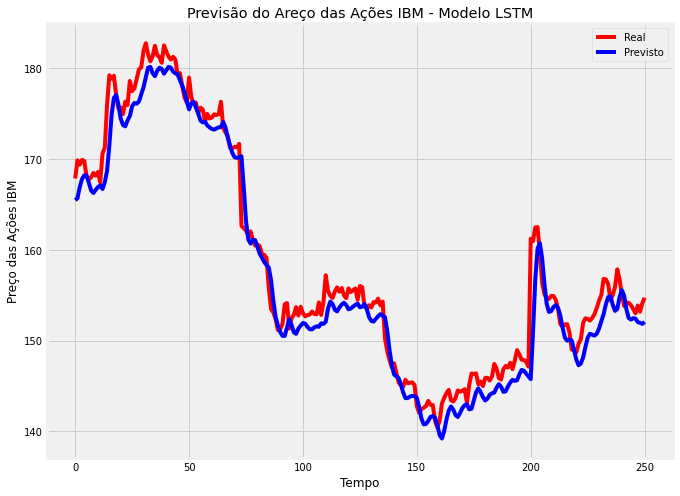

In [25]:
plt.figure(figsize=(10,8))
plt.plot(test_set, color='red',label='Real')
plt.plot(predicted_stock_price, color='blue',label='Previsto')
plt.title('Previsão do Areço das Ações IBM - Modelo LSTM')
plt.xlabel('Tempo')
plt.ylabel('Preço das Ações IBM')
plt.legend()
plt.show()

O modelo LSTM se ajustou muito bem com os dados e conseguimos reproduzir muito os preços.

## 6. Modelo2: GRU

A Unidade recorrente bloqueada (Gated Recurrent Units - GRU) não precisa usar uma unidade de memória para controlar o fluxo de informações como a unidade LSTM. Ele pode usar diretamente todos os estados ocultos sem nenhum controle. GRUs têm menos parâmetros e, portanto, podem treinar um pouco mais rápido ou precisam de menos dados para generalizar. 

GRUs são quase semelhantes aos LSTMs, exceto que têm duas portas: porta de redefinição e porta de atualização. A porta de redefinição determina como combinar a nova entrada para a memória anterior e a porta de atualização determina quanto do estado anterior deve ser mantido.

In [20]:
# arquiteta o modelo GRU
regressorGRU = Sequential()
# camada de entrada 
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# 1° camada GRU 
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# 2° camada GRU
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# 3° camada GRU 
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# camada de saída
regressorGRU.add(Dense(units=1))

#imprime a arquitetura do modelo
regressorGRU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 50)            7950      
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 60, 50)            15300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 60, 50)            15300     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)               

In [21]:
# Compila o RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Ajusta(fitting) o modelo com o conjunto de treino
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
19/19 [==============================] - 13s 220ms/step - loss: 0.1675
Epoch 2/50
19/19 [==============================] - 4s 218ms/step - loss: 0.0537
Epoch 3/50
19/19 [==============================] - 4s 222ms/step - loss: 0.0186
Epoch 4/50
19/19 [==============================] - 4s 220ms/step - loss: 0.0059
Epoch 5/50
19/19 [==============================] - 4s 224ms/step - loss: 0.0046
Epoch 6/50
19/19 [==============================] - 5s 270ms/step - loss: 0.0042
Epoch 7/50
19/19 [==============================] - 4s 222ms/step - loss: 0.0043
Epoch 8/50
19/19 [==============================] - 4s 222ms/step - loss: 0.0040
Epoch 9/50
19/19 [==============================] - 4s 219ms/step - loss: 0.0036
Epoch 10/50
19/19 [==============================] - 4s 221ms/step - loss: 0.0034
Epoch 11/50
19/19 [==============================] - 4s 223ms/step - loss: 0.0036
Epoch 12/50
19/19 [==============================] - 7s 380ms/step - loss: 0.0029
Epoch 13/50
19/19 [=====

## 7. Avaliando o Modelo2 GRU

In [22]:
# preparando os preços das previsões
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

Vamos calcular a raiz do erro quadrático médio para ver a qualidade do modelo.

In [23]:
rmse = math.sqrt(mean_squared_error(test_set,GRU_predicted_stock_price))
print("RMSE = {}.".format(rmse))

RMSE = 3.2999235690308946.


Obtemos um erro de 3.3. Esse valor é maior do que encontramos para o modelo LSTM, mas ainda sim é pequeno e valida a eficácia do GRU para este projeto.

Por fim, vamos fazer o gráfico dos valores previsto pelo GRU e dos preços reais.

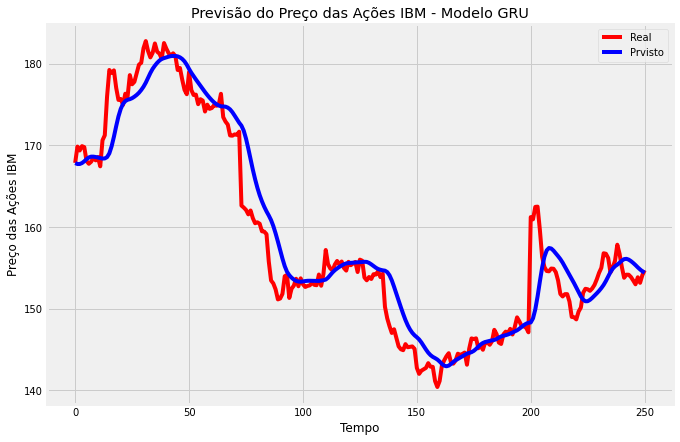

In [24]:
plt.figure(figsize=(10,7))
plt.plot(test_set, color='red',label='Real')
plt.plot(GRU_predicted_stock_price, color='blue',label='Prvisto')
plt.title('Previsão do Preço das Ações IBM - Modelo GRU')
plt.xlabel('Tempo')
plt.ylabel('Preço das Ações IBM')
plt.legend()
plt.show()

O modelo GRU conseguiu acompanhar a trajetória da curva real, porém com uma precisão menor das flutuações dos preços.

## 8. Conclusão

Criamos dois modelos de RNN para prever os preços em alta das açoes da IBM. Ambos os modelos conseguiram resultados satisfatórios. O modelo LSTM se sai melhor que o GRU no requisito precisão das flutuações dos preços e menor erro da previsão dos preços.